# Error Analysis for the Multi-label Model

In [1]:
! rsync -a /kaggle/input/mmdetection-v280/mmdetection /
! pip install /kaggle/input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3/
! pip install /kaggle/input/hpapytorchzoo/pytorch_zoo-master/
! pip install /kaggle/input/hpacellsegmentation/HPA-Cell-Segmentation/
! pip install /kaggle/input/iterative-stratification/iterative-stratification-master/

! cp -r /kaggle/input/kgl-humanprotein-data/kgl_humanprotein_data /
! cp -r /kaggle/input/humanpro/kgl_humanprotein /

import sys
sys.path.append('/kgl_humanprotein/')

Processing /kaggle/input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3
  Created wheel for mmpycocotools: filename=mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl size=272913 sha256=86ad41ea3c498461a886b3b6f1996452d17675530e82ab3ecb5d60169e1d9658
  Stored in directory: /root/.cache/pip/wheels/80/e0/da/3288fdf3965b5c9090f368462db9d28be2c82013f51821090a
Successfully built mmpycocotools
Processing /kaggle/input/hpapytorchzoo/pytorch_zoo-master
  Created wheel for pytorch-zoo: filename=pytorch_zoo-0.0.0-py3-none-any.whl size=30139 sha256=c32b2cb07610f95c22e1c12e2a2bbdbbebab098a6d3ac1fce48b970d24c4ee89
  Stored in directory: /root/.cache/pip/wheels/7f/18/21/aff5a8914e22461b2b025a9629c2b70464c36183caaf12bc09
Successfully built pytorch-zoo
Processing /kaggle/input/hpacellsegmentation/HPA-Cell-Segmentation
  Created wheel for hpacellseg: filename=hpacellseg-0.1.8-py3-none-any.whl size=14815 sha256=3dc616ea24cbd79418d9edf433d5f9ca7f40c4de1e9e6adeadf2d78cb707ced0
  Stored in di

In [2]:
import os
import time
from pathlib import Path
import shutil
import zipfile
import functools
import multiprocessing
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import KFold,StratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import torch
from torch.backends import cudnn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import DataParallel
import matplotlib.pyplot as plt
from tqdm import tqdm

from kgl_humanprotein.utils.common_util import *
from kgl_humanprotein.config.config import *
from kgl_humanprotein.data_process import *
from kgl_humanprotein.datasets.tool import image_to_tensor
from kgl_humanprotein.datasets.protein_dataset import *
from kgl_humanprotein.networks.imageclsnet import init_network
from kgl_humanprotein.layers.loss import *
from kgl_humanprotein.layers.scheduler import *
from kgl_humanprotein.utils.augment_util import train_multi_augment2
from kgl_humanprotein.utils.log_util import Logger
from kgl_humanprotein.run.train import *

run on 9e7d51700448


In [3]:
%cd /kaggle

/kaggle


# Load multi-label meta data

In [4]:
dir_data = Path('/kaggle/input')
dir_mdata = Path('/kaggle/mdata')

In [5]:
%%time
df_cells = pd.read_feather('/kaggle/input/humanpro-data-multilabel-cells-meta/train.feather')

CPU times: user 682 ms, sys: 460 ms, total: 1.14 s
Wall time: 3.02 s


In [6]:
dir_mdata_raw = dir_mdata/'raw'
dir_mdata_raw.mkdir(exist_ok=True, parents=True)

df_cells.to_feather(dir_mdata_raw/'train.feather')

In [7]:
del df_cells

# Filter samples

In [8]:
# Limit number of samples per label

def cap_number_per_label(df_cells, cap=10_000, idx_start=0):
    df_cells_cap = pd.DataFrame()
    for label in df_cells.Target.unique():
        df = df_cells[df_cells.Target==label]
        if len(df) > cap:
            df = df.iloc[idx_start:idx_start + cap]
        df_cells_cap = df_cells_cap.append(df, ignore_index=True)
    return df_cells_cap

In [9]:
df_cells = pd.read_feather(dir_mdata_raw/'train.feather')

In [10]:
# Filter remove samples with label ''

df_cells = df_cells[df_cells.Target != ''].reset_index(drop=True)

In [11]:
df_cells = cap_number_per_label(df_cells, cap=5_000, idx_start=0) 

In [12]:
df_cells.Target.value_counts()

13        5000
1         5000
0         5000
2         5000
5         5000
          ... 
0|1|2        1
0|7|16       1
6|14         1
2|3          1
5|17         1
Name: Target, Length: 149, dtype: int64

In [13]:
df_cells.to_feather(dir_mdata_raw/'train.feather')

# Labels one-hot encoding

In [14]:
%%time
generate_meta(dir_mdata, 'train.feather')

CPU times: user 19.9 s, sys: 280 ms, total: 20.2 s
Wall time: 20.1 s


# Split generation

In [15]:
%%time
train_meta = pd.read_feather(dir_mdata/'meta'/'train_meta.feather')
create_random_split(dir_mdata, train_meta, n_splits=5, alias='random')
del train_meta

Nucleoplasm 7922 1981
Nuclear membrane 4720 1180
Nucleoli 5069 1267
Nucleoli fibrillar center 3050 762
Nuclear speckles 4136 1034
Nuclear bodies 5091 1272
Endoplasmic reticulum 1601 400
Golgi apparatus 4715 1178
Intermediate filaments 2322 580
Actin filaments 3698 924
Microtubules 4177 1044
Mitotic spindle 0 0
Centrosome 3283 821
Plasma membrane 5771 1443
Mitochondria 4513 1128
Aggresome 488 121
Cytosol 6082 1521
Vesicles and punctate cytosolic patterns 805 202
Negative 0 0
create split file: /kaggle/mdata/split/random_folds5/random_train_cv0.feather, shape: (60311, 29)
create split file: /kaggle/mdata/split/random_folds5/random_valid_cv0.feather, shape: (15082, 29)
create split file: /kaggle/mdata/split/random_folds5/random_train_cv1.feather, shape: (60334, 29)
create split file: /kaggle/mdata/split/random_folds5/random_valid_cv1.feather, shape: (15059, 29)
create split file: /kaggle/mdata/split/random_folds5/random_train_cv2.feather, shape: (60368, 29)
create split file: /kaggle/mdat

# Validation

In [16]:
# set cuda visible device

gpu_id = '0'

os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id
cudnn.benchmark = True

# set random seeds
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

In [17]:
# Load trained model

arch = 'class_densenet121_dropout'
num_classes = len(LABEL_NAME_LIST)
in_channels = 4
resume = Path('/kaggle/input/humanpro-classifier-crop-multilabeltrained/results/models/'
              'external_crop256_focal_slov_hardlog_class_densenet121_dropout_i384_aug2_5folds/'
              'fold0/final.pth')

model_params = {}
model_params['architecture'] = arch
model_params['num_classes'] = num_classes
model_params['in_channels'] = in_channels
model = init_network(model_params)

# move network to gpu
model = DataParallel(model)
model.to(DEVICE)

checkpoint = torch.load(resume)
model.module.load_state_dict(checkpoint['state_dict'])

>> Using pre-trained model.


<All keys matched successfully>

In [18]:
# Load validation samples

img_size = 384
crop_size = 256 
batch_size = 64
split_name = 'random_folds5'
fold = 0
workers = 3
pin_memory = True


valid_file = Path(dir_mdata/'split'/split_name/f'random_valid_cv{fold}.feather')
df_cells_valid = pd.read_feather(valid_file).sample(100).reset_index(drop=True)
df_cells_valid.to_feather(valid_file)

assert valid_file.exists()
    
valid_dataset = ProteinDataset(dir_data, valid_file, img_size=img_size, is_trainset=True,
                               return_label=True, in_channels=in_channels, transform=None,
                               crop_size=crop_size, random_crop=False)
    
valid_loader = DataLoader(valid_dataset, sampler=SequentialSampler(valid_dataset),
                          batch_size=batch_size, drop_last=False, 
                          num_workers=workers, pin_memory=pin_memory)

In [19]:
# loss function

criterion = FocalSymmetricLovaszHardLogLoss().to(DEVICE)
focal_loss = FocalLoss().to(DEVICE)

In [20]:
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import f1_score

def validate(valid_loader, model, criterion, epoch, focal_loss, threshold=0.5):
    batch_time = AverageMeter()
    losses = AverageMeter()
    accuracy = AverageMeter()

    # switch to evaluate mode
    model.eval()

    probs_list = []
    labels_list = []
    logits_list = []
    loss_list = []
    acc_list = []

    end = time.time()
    for it, iter_data in enumerate(valid_loader, 0):
        images, labels, indices = iter_data
        images = Variable(images.to(DEVICE))
        labels = Variable(labels.to(DEVICE))

        outputs = model(images)
        loss = criterion(outputs, labels, epoch=epoch)

        logits = outputs
        probs = F.sigmoid(logits)
        acc = multi_class_acc(probs, labels)

        probs_list.append(probs.cpu().detach().numpy())
        labels_list.append(labels.cpu().detach().numpy())
        logits_list.append(logits.cpu().detach().numpy())
        loss_list.append(loss.item())
        acc_list.append(acc.item())

        losses.update(loss.item())
        accuracy.update(acc.item())

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    probs = np.vstack(probs_list)
    y_true = np.vstack(labels_list)
    logits = np.vstack(logits_list)
    loss = np.vstack(loss_list)
    acc = np.vstack(acc_list)
    valid_focal_loss = focal_loss.forward(torch.from_numpy(logits), torch.from_numpy(y_true))

    y_pred = probs > threshold
    kaggle_score = f1_score(y_true, y_pred, average='macro')

#     return losses.avg, accuracy.avg, valid_focal_loss, kaggle_score
    return losses.avg, accuracy.avg, valid_focal_loss, kaggle_score, probs, y_true, logits, loss, acc

In [21]:
%%time 

with torch.no_grad():
    (valid_loss, valid_acc, valid_focal_loss, kaggle_score, 
     probs, y_true, logits, loss, acc) = validate(valid_loader, model, criterion, 0, focal_loss)

CPU times: user 447 ms, sys: 633 ms, total: 1.08 s
Wall time: 7.64 s


In [22]:
loss = []
for i in range(len(logits)):
#     loss.append(criterion(torch.from_numpy(logits[[i]]), torch.from_numpy(y_true[[i]])))
    loss.append(focal_loss.forward(torch.from_numpy(logits[[i]]), torch.from_numpy(y_true[[i]])))
    
loss = np.array(loss)

In [23]:
prediction_threshold = 0.3

preds = (probs > prediction_threshold).astype(np.int16)

ptargets = [np.where(pred)[0] for pred in preds]
ptargets = ['|'.join(str(class_id) for class_id in target) for target in ptargets]

targets = pd.read_feather(valid_file).Target.values

# Worst predictions

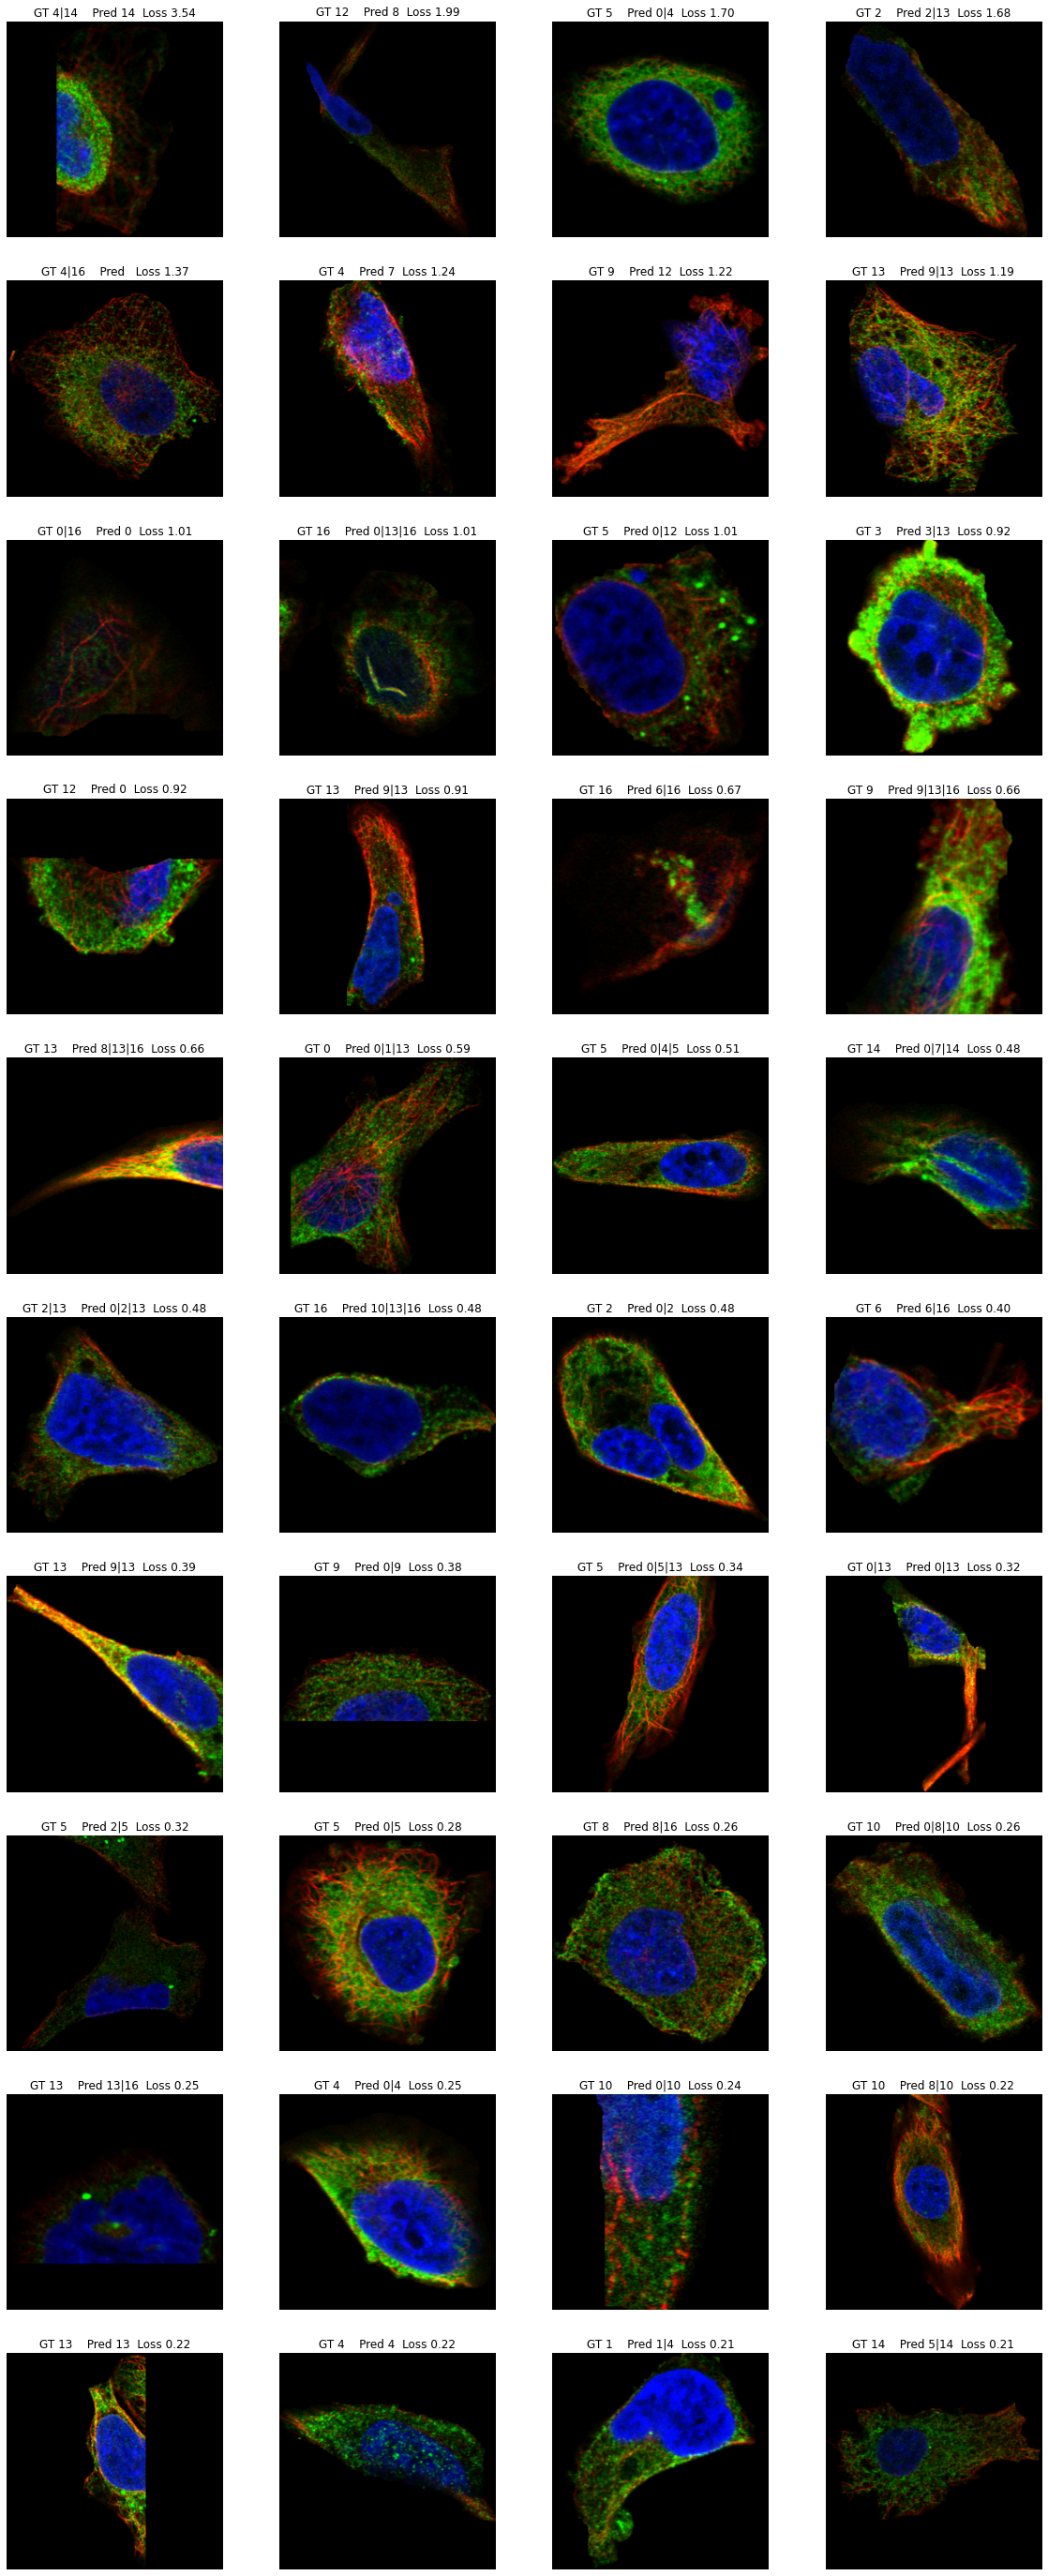

In [24]:
ntop = 40
idxs = loss.flatten().argsort()[::-1][:ntop]

ncols = 4
nrows = (ntop - 1) // ncols + 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
axs = axs.flatten()
for ax in axs:
    ax.axis('off')

for ax, i in zip(axs, idxs):
    img = valid_dataset[i][0].permute(1, 2, 0).numpy()
    ax.imshow(img[...,[0, 3, 2]])
    
    ax.set_title(f'GT {targets[i]}    Pred {ptargets[i]}  Loss {loss[i].item():.2f}')

# Best predictions

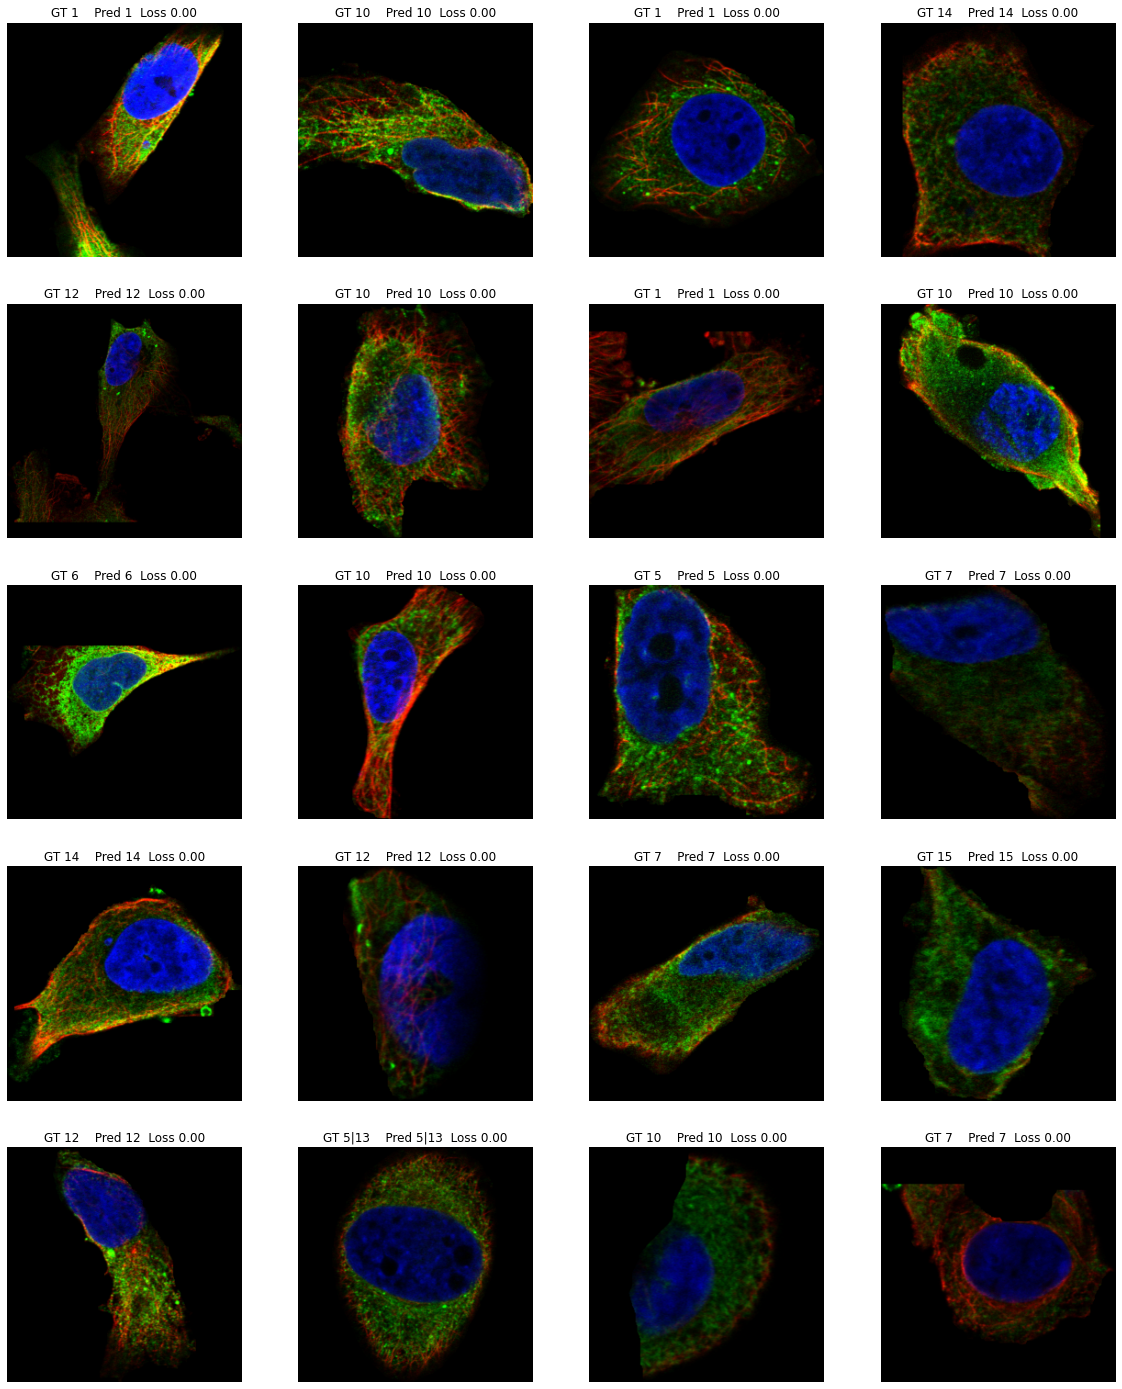

In [25]:
ntop = 20
idxs = loss.flatten().argsort()[:ntop]

ncols = 4
nrows = (ntop - 1) // ncols + 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
axs = axs.flatten()
for ax in axs:
    ax.axis('off')

for ax, i in zip(axs, idxs):
    img = valid_dataset[i][0].permute(1, 2, 0).numpy()
    ax.imshow(img[...,[0, 3, 2]])
    
    ax.set_title(f'GT {targets[i]}    Pred {ptargets[i]}  Loss {loss[i].item():.2f}')